# **_005_Exploratory Data Analysis of API data_**

In [1]:
import pandas as pd
from langdetect import detect
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from langdetect import detect
from tqdm import tqdm


## **_Data loading_**

In [2]:
df1 = pd.read_csv("../data/api_data_part1.csv")
df2= pd.read_csv("../data/api_data_part2.csv")

df = pd.concat([df1, df2], ignore_index=True)
df.head()


,artist,country,award,gender,album_count
0,10cc,NaN,No awards,Unknown,23
1,110,NaN,No awards,Unknown,0
2,13,NaN,No awards,Unknown,0
3,19,NaN,No awards,Unknown,5
4,3 Doors Down,NaN,No awards,Unknown,10


## **_Dataset information_**

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18828 entries, 0 to 18827
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   artist       18828 non-null  object
 1   country      10299 non-null  object
 2   award        18828 non-null  object
 3   gender       18828 non-null  object
 4   album_count  18828 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 735.6+ KB


In [4]:
df.shape

(18828, 5)

In [5]:
df.isna().sum()

artist            0
country        8529
award             0
gender            0
album_count       0
dtype: int64

## **_Data cleaning_**

### **_Null values_**

The only column in which nulls are present is country.

For a better handling of the data, the null values are filled with ‘Unknown’, since this is not a column to which an imputation method can be applied due to the nature of its data.

In [6]:
df['country'] = df['country'].fillna('Unknown')

In [7]:
df.isna().sum()

artist         0
country        0
award          0
gender         0
album_count    0
dtype: int64

### **_Duplicated values_**

A list of words that usually appear in non-English awards is defined and a cache is created to store the results of the language detection so as not to have to do the detection several times for the same text.

In [10]:
non_english_words = [
    "stär um", "para", "prêmio", "premio", "prix", "voor", "de", "sus", "la", "das", "del", "der", "des",
    "el", "le", "pe", "stella", "sulla", "nagroda", "carriera", "réalta", "premi", "xelata",
    "tähti", "æresdoktor", "famen", "doktor", "oriel", "anfarwolion", "auf dem", "or merit", "kpakpando", "stäär üüb"
]
award_lang_cache = {}

It detects if the text of an award is in English; if it is not English, it is discarded. In addition, it is verified that it does not contain any of the words in the `non_english_words` list (to avoid false positives).

In [11]:
def is_english_filtered(text):
    text_l = str(text).lower().strip()
    if text not in award_lang_cache:
        try:
            award_lang_cache[text] = detect(text)
        except:
            award_lang_cache[text] = "unknown"
    if award_lang_cache[text] != "en":
        return False
    return not any(palabra in text_l for palabra in non_english_words)

Records that do have an award are filtered out and the above filtering function is applied to keep only English and relevant awards.

In [12]:
df_valid_awards = df[df['award'].notna()].copy()
tqdm.pandas(desc="Filtrando premios válidos")
df_valid_awards = df_valid_awards[df_valid_awards['award'].progress_apply(is_english_filtered)]

Filtrando premios válidos: 100%|██████████| 18828/18828 [00:11<00:00, 1656.00it/s]


- Unique awards are grouped by artist.

- Count how many awards each artist has `award_count`.

- A boolean column is created to indicate if he/she has won a Grammy `won_grammy`.

- A list of awards is generated as a string `awards_list`.

In [13]:
premios_agrupados = df_valid_awards.groupby("artist")["award"].apply(lambda x: sorted(set(x))).reset_index()
premios_agrupados["award_count"] = premios_agrupados["award"].apply(len)
premios_agrupados["won_grammy"] = premios_agrupados["award"].apply(lambda premios: any("grammy" in str(premio).lower() for premio in premios))
premios_agrupados["awards_list"] = premios_agrupados["award"].apply(lambda x: "; ".join(x))

Other important attributes are grouped by artist (Country, Genre, Number of albums). The most common value is taken for each (if there is inconsistent or repeated data).

In [14]:
def valor_mas_comun(serie):
    if not serie.mode().empty:
        return serie.mode().iloc[0]
    elif not serie.dropna().empty:
        return serie.dropna().iloc[0]
    else:
        return "Unknown"
    
grouped_attributes = df.groupby("artist").agg({
    "country": valor_mas_comun,
    "gender": valor_mas_comun,
    "album_count": valor_mas_comun
}).reset_index()

The award information is combined with the general attributes of the artists and missing values are filled in.

In [15]:
df_final = grouped_attributes.merge(premios_agrupados.drop(columns=["award"]), on="artist", how="left")

df_final["award_count"] = df_final["award_count"].fillna(0).astype(int)
df_final["won_grammy"] = df_final["won_grammy"].fillna(False)
df_final["awards_list"] = df_final["awards_list"].fillna("No awards")


The columns are sorted so that the final DataFrame is clean and tidy.

In [ ]:
df_final = df_final[[
    "artist", "gender", "country", "award_count",
    "won_grammy", "awards_list", "album_count"
]]

df_final.head()

In [25]:
df_final.shape

(9326, 7)

### **_Analysis_**

#### **_Distribution of the number of albums by artist_**

- Distribution skewed to the right ("long tail" distribution).

- There are a few extremely productive artists who have released a much higher than average number of albums.

- This is a typical pattern in many creative industries: most produce little, a few produce a great deal.

- Most artists have a low number of albums released, while very few have more than tens or hundreds of albums.

Text(0, 0.5, 'Number of artists')

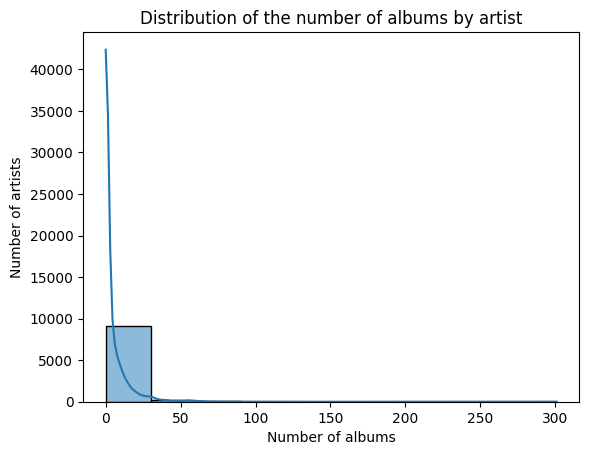

In [16]:
fig1, ax1 = plt.subplots()
sns.histplot(df_final["album_count"], bins=10, kde=True, ax=ax1)
ax1.set_title("Distribution of the number of albums by artist")
ax1.set_xlabel("Number of albums")
ax1.set_ylabel("Number of artists")

#### **_Artists who won at least one Grammy_**

Of all the artists considered, the vast majority have not won a Grammy, highlighting how difficult it is to obtain this recognition in the music industry.

C:\Users\natym\AppData\Local\Temp\ipykernel_23644\938591425.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_final, x="won_grammy", palette="Set2")


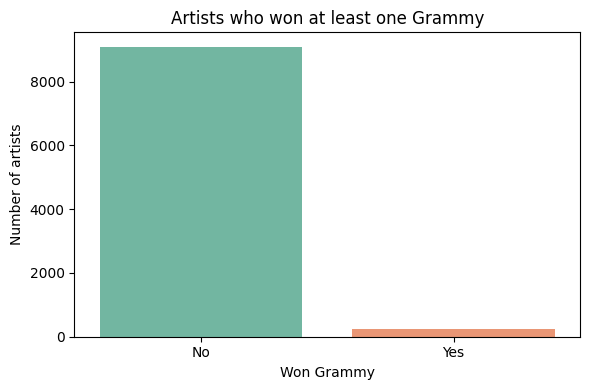

In [17]:
plt.figure(figsize=(6, 4))
sns.countplot(data=df_final, x="won_grammy", palette="Set2")
plt.title("Artists who won at least one Grammy")
plt.xticks([0, 1], ["No", "Yes"])
plt.xlabel("Won Grammy")
plt.ylabel("Number of artists")
plt.tight_layout()
plt.show()

#### **_Relationship between albums and awards_**

- Number of albums does not guarantee awards, there are artists with many albums but few awards.

- Having won a Grammy usually goes hand in hand with more awards in general, although it is not an absolute rule.

- Most artists, both Grammy winners and non-Grammy winners, have fewer than 50 albums and fewer than 5 awards.

Text(0, 0.5, 'Number of awards')

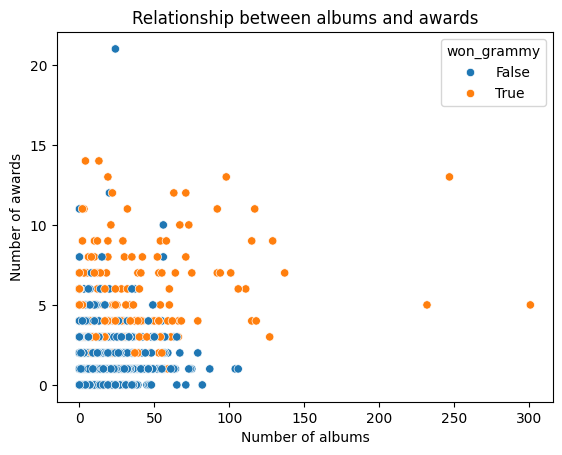

In [18]:
fig3, ax3 = plt.subplots()
sns.scatterplot(data=df_final, x="album_count", y="award_count", hue="won_grammy", ax=ax3)
ax3.set_title("Relationship between albums and awards")
ax3.set_xlabel("Number of albums")
ax3.set_ylabel("Number of awards")

#### **_Countries with the most awarded artists_**

Most of the awarded artists in this dataset are of unknown nationality. After that, the United States leads by quite a bit over the rest. Then there is a much more even distribution among other prominent countries.

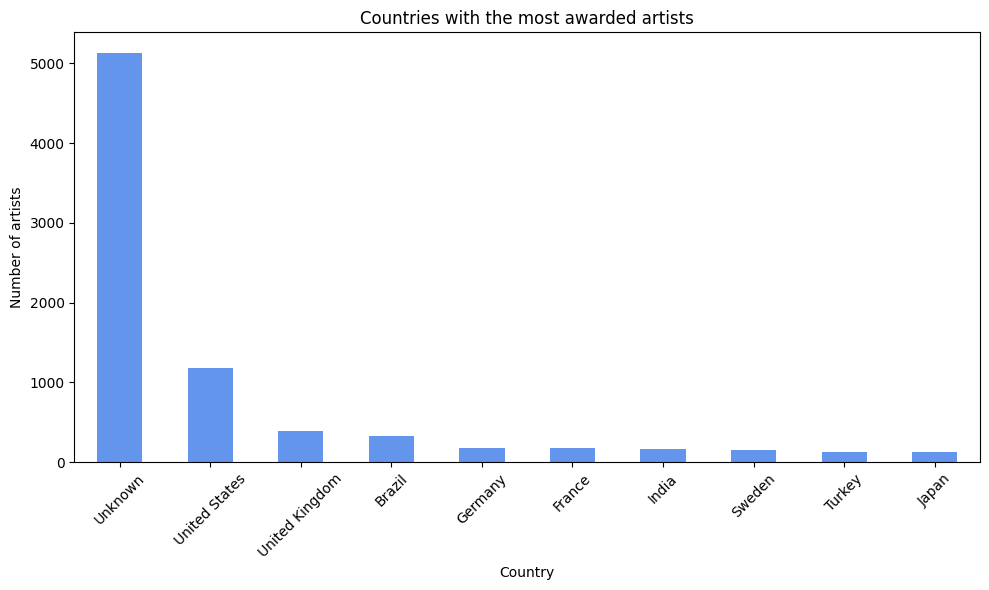

In [19]:
plt.figure(figsize=(10, 6))
df_final["country"].value_counts().head(10).plot(kind="bar", color="cornflowerblue")
plt.title("Countries with the most awarded artists")
plt.ylabel("Number of artists")
plt.xlabel("Country")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### **_Distribution of number of awards per artist_**

- The distribution is highly skewed to the right, most artists have few awards, and there are very few artists who accumulate a large number.

- This is typical behavior in phenomena such as the distribution of success in art or entertainment, a few artists accumulate many awards, while most are left with one or two.

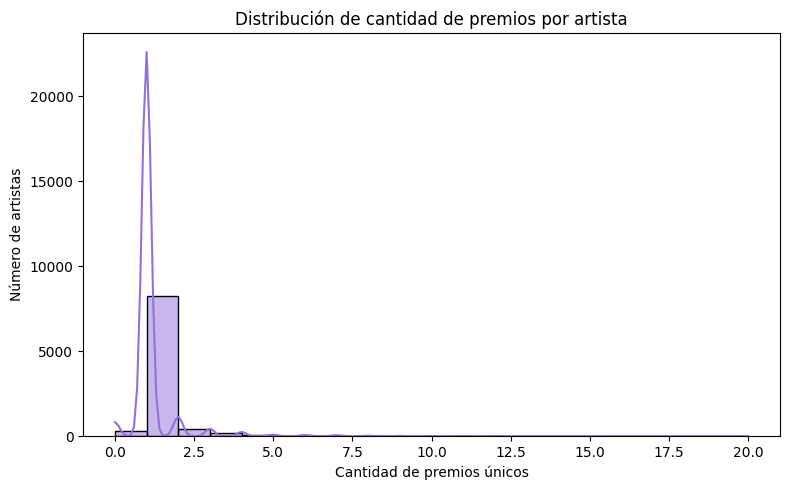

In [ ]:
plt.figure(figsize=(8, 5))
sns.histplot(df_final["award_count"], bins=20, kde=True, color="mediumpurple")
plt.title("Distribution of number of awards per artist")
plt.xlabel("Number of unique awards")
plt.ylabel("Number of artists")
plt.tight_layout()
plt.show()

#### **_Total awards by country_**

Most of the music awards in the dataset are associated with artists whose country of origin is unknown, suggesting a significant lack of geographic information in the data. However, excluding this group, the United States leads by a wide margin in terms of awards received, followed by countries with strong music industries such as the United Kingdom, Brazil and Canada. This reflects a possible concentration of recognition in regions with greater international projection and resources in the music industry.

C:\Users\natym\AppData\Local\Temp\ipykernel_23644\2563343561.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=premios_por_pais.values, y=premios_por_pais.index, palette="Blues_d")


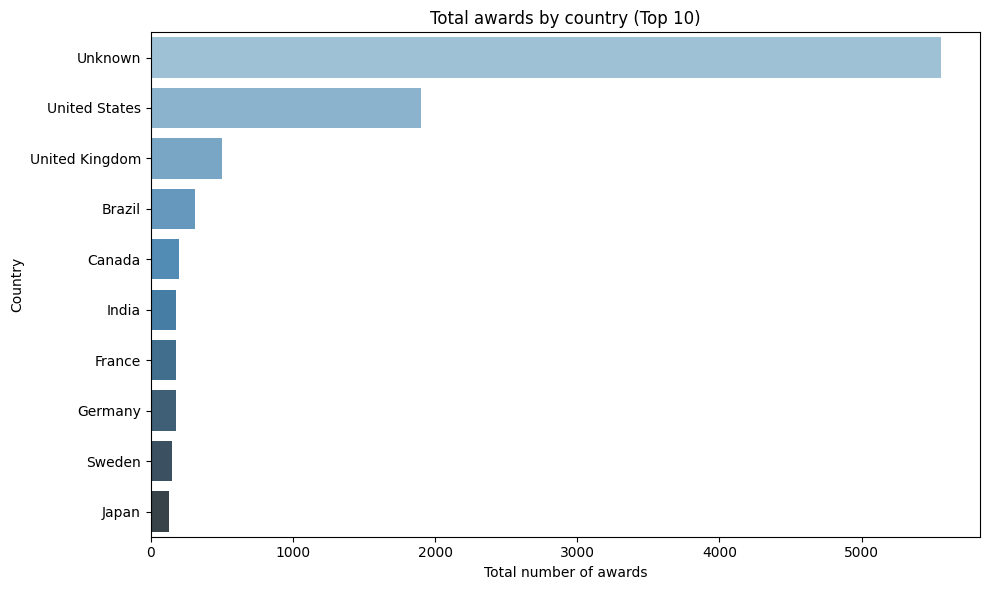

In [20]:
premios_por_pais = df_final.groupby("country")["award_count"].sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x=premios_por_pais.values, y=premios_por_pais.index, palette="Blues_d")
plt.title("Total awards by country (Top 10)")
plt.xlabel("Total number of awards")
plt.ylabel("Country")
plt.tight_layout()
plt.show()

#### **_Grammy artists by gender_**

There is a clear overrepresentation of male artists among Grammy winners compared to other gender identities. In addition, a significant portion of the data lacks information on gender, which limits the analysis of diversity. This distribution reflects potential historical gender gaps in the music industry and underscores the need for improved data collection to include diverse and complete identities.

C:\Users\natym\AppData\Local\Temp\ipykernel_23644\3248001964.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=grammy_por_genero.index, y=grammy_por_genero.values, palette="Set2")


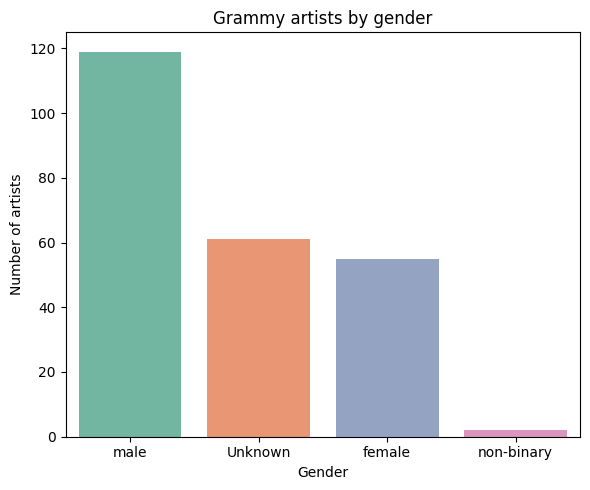

In [22]:
grammy_por_genero = df_final[df_final["won_grammy"] == True]["gender"].value_counts()

plt.figure(figsize=(6, 5))
sns.barplot(x=grammy_por_genero.index, y=grammy_por_genero.values, palette="Set2")
plt.title("Grammy artists by gender")
plt.xlabel("Gender")
plt.ylabel("Number of artists")
plt.tight_layout()
plt.show()